<a href="https://colab.research.google.com/github/Jabaananth/Military-Safety-computer-vision-object-detection-/blob/main/Military_Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics --upgrade
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
from google.colab import output
import IPython

display(IPython.display.Javascript('''
   function ClickConnect(){
      btn = document.querySelector("colab-connect-button")
      if (btn != null){btn.click()}
      btn = document.getElementById('ok')
      if (btn != null){btn.click()}
   }
   setInterval(ClickConnect,60000)
'''))

<IPython.core.display.Javascript object>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
yaml_text = """
path: /content/drive/MyDrive/Military/military_object_dataset
train: c/content/drive/MyDrive/Military/military_object_dataset/train
val: /content/drive/MyDrive/Military/military_object_dataset/val
test: /content/drive/MyDrive/Military/military_object_dataset/test

names:
  0: camouflage_soldier
  1: weapon
  2: military_tank
  3: military_truck
  4: military_vehicle
  5: civilian
  6: soldier
  7: civilian_vehicle
  8: military_artillery
  9: trench
  10: military_aircraft
  11: military_warship
"""
with open("military_dataset.yaml", "w") as f:
    f.write(yaml_text)


In [5]:
# import os
# import shutil

# original_dataset = "/content/drive/MyDrive/Military/military_object_dataset"
# output_dataset = "/content/reduced_dataset"

# # Original to new class ID mapping
# class_map = {1: 0, 3: 1, 4: 2, 8: 3, 11: 4}

# def process_split(split):
#     img_in = f"{original_dataset}/{split}/images"
#     lbl_in = f"{original_dataset}/{split}/labels"
#     img_out = f"{output_dataset}/{split}/images"
#     lbl_out = f"{output_dataset}/{split}/labels"

#     os.makedirs(img_out, exist_ok=True)
#     os.makedirs(lbl_out, exist_ok=True)

#     for file in os.listdir(lbl_in):
#         label_path = os.path.join(lbl_in, file)
#         new_lines = []

#         with open(label_path, "r") as f:
#             for line in f:
#                 parts = line.strip().split()
#                 cls = int(parts[0])
#                 if cls in class_map:
#                     new_lines.append(f"{class_map[cls]} {' '.join(parts[1:])}\n")

#         if new_lines:
#             # Write new label file
#             with open(os.path.join(lbl_out, file), "w") as f:
#                 f.writelines(new_lines)

#             # Copy corresponding image
#             img_file = file.replace(".txt", ".jpg")
#             src_img = os.path.join(img_in, img_file)
#             dst_img = os.path.join(img_out, img_file)
#             if os.path.exists(src_img):
#                 shutil.copy(src_img, dst_img)

# # Run on all splits
# for split in ['train', 'val', 'test']:
#     process_split(split)


In [6]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor, as_completed

original_dataset = "/content/drive/MyDrive/Military/military_object_dataset"
output_dataset = "/content/reduced_dataset"
class_map = {1: 0, 3: 1, 4: 2, 8: 3, 11: 4}

def process_file(file, img_in, lbl_in, img_out, lbl_out):
    label_path = os.path.join(lbl_in, file)
    new_lines = []

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            if cls in class_map:
                new_lines.append(f"{class_map[cls]} {' '.join(parts[1:])}\n")

    if new_lines:
        # Write new label file
        with open(os.path.join(lbl_out, file), "w") as f:
            f.writelines(new_lines)

        # Copy image file
        img_file = file.replace(".txt", ".jpg")
        src_img = os.path.join(img_in, img_file)
        dst_img = os.path.join(img_out, img_file)
        shutil.copy(src_img, dst_img)

def process_split(split):
    img_in = f"{original_dataset}/{split}/images"
    lbl_in = f"{original_dataset}/{split}/labels"
    img_out = f"{output_dataset}/{split}/images"
    lbl_out = f"{output_dataset}/{split}/labels"

    os.makedirs(img_out, exist_ok=True)
    os.makedirs(lbl_out, exist_ok=True)

    files = os.listdir(lbl_in)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for file in files:
            futures.append(executor.submit(process_file, file, img_in, lbl_in, img_out, lbl_out))
        for future in as_completed(futures):
            future.result()  # to catch exceptions if any

if __name__ == "__main__":
    for split in ['train', 'val', 'test']:
        process_split(split)


# Updated YAML file


In [7]:
yaml_text = """
path: /content/reduced_dataset
train: train/images
val: val/images
test: test/images

names:
  0: weapon
  1: military_truck
  2: military_vehicle
  3: military_artillery
  4: military_warship
"""
with open("/content/reduced_dataset.yaml", "w") as f:
    f.write(yaml_text)


# EDA (Exploratory Data Analysis)

In [8]:
import os

for split in ['train', 'val', 'test']:
    img_path = f"/content/drive/MyDrive/Military/military_object_dataset/{split}/images"
    count = len(os.listdir(img_path))
    print(f"{split.title()} set: {count} images")


Train set: 21978 images
Val set: 2941 images
Test set: 1396 images


In [9]:
# Class Frequency Distribution

from collections import Counter

labels_path = "/content/drive/MyDrive/Military/military_object_dataset/train/labels"
class_counts = Counter()

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Map class IDs to names
class_names = [
    "camouflage_soldier", "weapon", "military_tank", "military_truck",
    "military_vehicle", "civilian", "soldier", "civilian_vehicle",
    "military_artillery", "trench", "military_aircraft", "military_warship"
]

for cid, count in sorted(class_counts.items()):
    print(f"{class_names[cid]}: {count}")


camouflage_soldier: 4477
weapon: 1210
military_tank: 17454
military_truck: 1245
military_vehicle: 1963
civilian: 52
soldier: 6502
civilian_vehicle: 519
military_artillery: 439
trench: 4
military_aircraft: 7337
military_warship: 2134


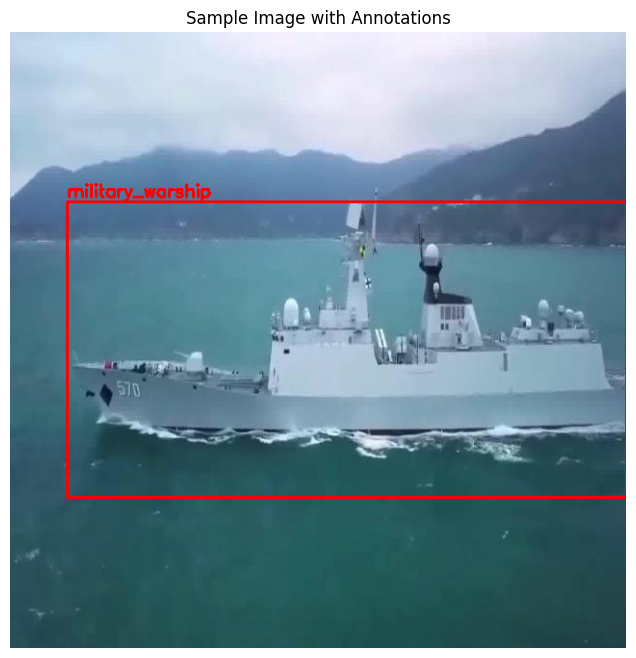

In [10]:
# Visualize Sample bounding boxes

import cv2
import matplotlib.pyplot as plt

img_dir = "/content/drive/MyDrive/Military/military_object_dataset/train/images"
label_dir = "/content/drive/MyDrive/Military/military_object_dataset/train/labels"

# Pick a sample image
img_file = os.listdir(img_dir)[10]
img_path = os.path.join(img_dir, img_file)
label_path = os.path.join(label_dir, img_file.replace(".jpg", ".txt"))

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Draw bounding boxes
with open(label_path, "r") as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.strip().split())
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, class_names[int(cls)], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Sample Image with Annotations")
plt.show()


# YOLOv8 Model Training

In [11]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8n (nano) model - fast and lightweight
model = YOLO("yolov8n.pt")

# Start training
model.train(
    data="/content/drive/MyDrive/Military/military_object_dataset/military_dataset.yaml",       # Dataset config
    epochs=5,                          # You can increase for better performance
    imgsz=250,                          # Image size (recommended: 640 or 512)
    batch=8,                            # Based on GPU RAM
    name="military_safety_yolov8",      # Folder name under runs/train
    patience=10,                        # Early stopping if no improvement
    save_period=5
)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Military/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=250, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_safety_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8fa4d87d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Training for selected classes

In [12]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(
    data="/content/drive/MyDrive/Military/military_object_dataset/military_dataset.yaml",
    epochs=5,
    imgsz=250,
    batch=8,
    name="military_subset_yolo",
    patience=5,        # stops early if no improvement
    save_period=5      # saves weights every 5 epochs
)



Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Military/military_object_dataset/military_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=250, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=military_subset_yolo, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8f9236d580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [13]:
# Step 1: Check folder size
!du -sh runs/detect/military_subset_yolo

# Step 2: Compress the folder
!tar -czf military_subset_yolo.tar.gz -C runs/detect military_subset_yolo

# Step 3: Check compressed file size
!du -sh military_subset_yolo.tar.gz

# Step 4: Copy to Google Drive with verbose output
!cp -v military_subset_yolo.tar.gz /content/drive/MyDrive/

# Step 5: Verify that the file is copied
!ls -lh /content/drive/MyDrive/military_subset_yolo.tar.gz

# Optional: Check available disk space
!df -h


33M	runs/detect/military_subset_yolo
28M	military_subset_yolo.tar.gz
'military_subset_yolo.tar.gz' -> '/content/drive/MyDrive/military_subset_yolo.tar.gz'
-rw------- 1 root root 28M Oct  4 12:33 /content/drive/MyDrive/military_subset_yolo.tar.gz
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   42G   72G  37% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G  236K  5.7G   1% /dev/shm
/dev/root       2.0G  1.2G  764M  62% /usr/sbin/docker-init
/dev/sda1        74G   44G   31G  59% /opt/bin/.nvidia
tmpfs           6.4G  216K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G  4.2G   11G  28% /content/drive


In [14]:
!cp -r runs/detect/military_subset_yolo /content/drive/MyDrive/military_subset_yolo/



# Model Evaluation

In [15]:
# load best checkpoint

from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/military_subset_yolo/weights/best.pt")



In [16]:
# Evaluate on validation dataset

metrics = model.val()

# Print key metrics
print("Precision:", metrics.box.p)
print("Recall:", metrics.box.r)
print("mAP@0.5:", metrics.box.map50)
print("mAP@0.5:0.95:", metrics.box.map)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1868.9±1169.6 MB/s, size: 843.0 KB)
val: Scanning /content/reduced_dataset/val/labels.cache... 533 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 533/533 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 4.7it/s 7.3s
                   all        533        930      0.479      0.552       0.47      0.294
                weapon        222        358      0.608      0.564      0.569      0.361
        military_truck         84        148      0.372      0.628      0.466      0.276
      military_vehicle        149        307      0.414      0.642      0.447      0.279
    military_artillery         85        117      0.521      0.376      0.396      0.259
Speed: 0.1ms preprocess, 3.2ms inference, 

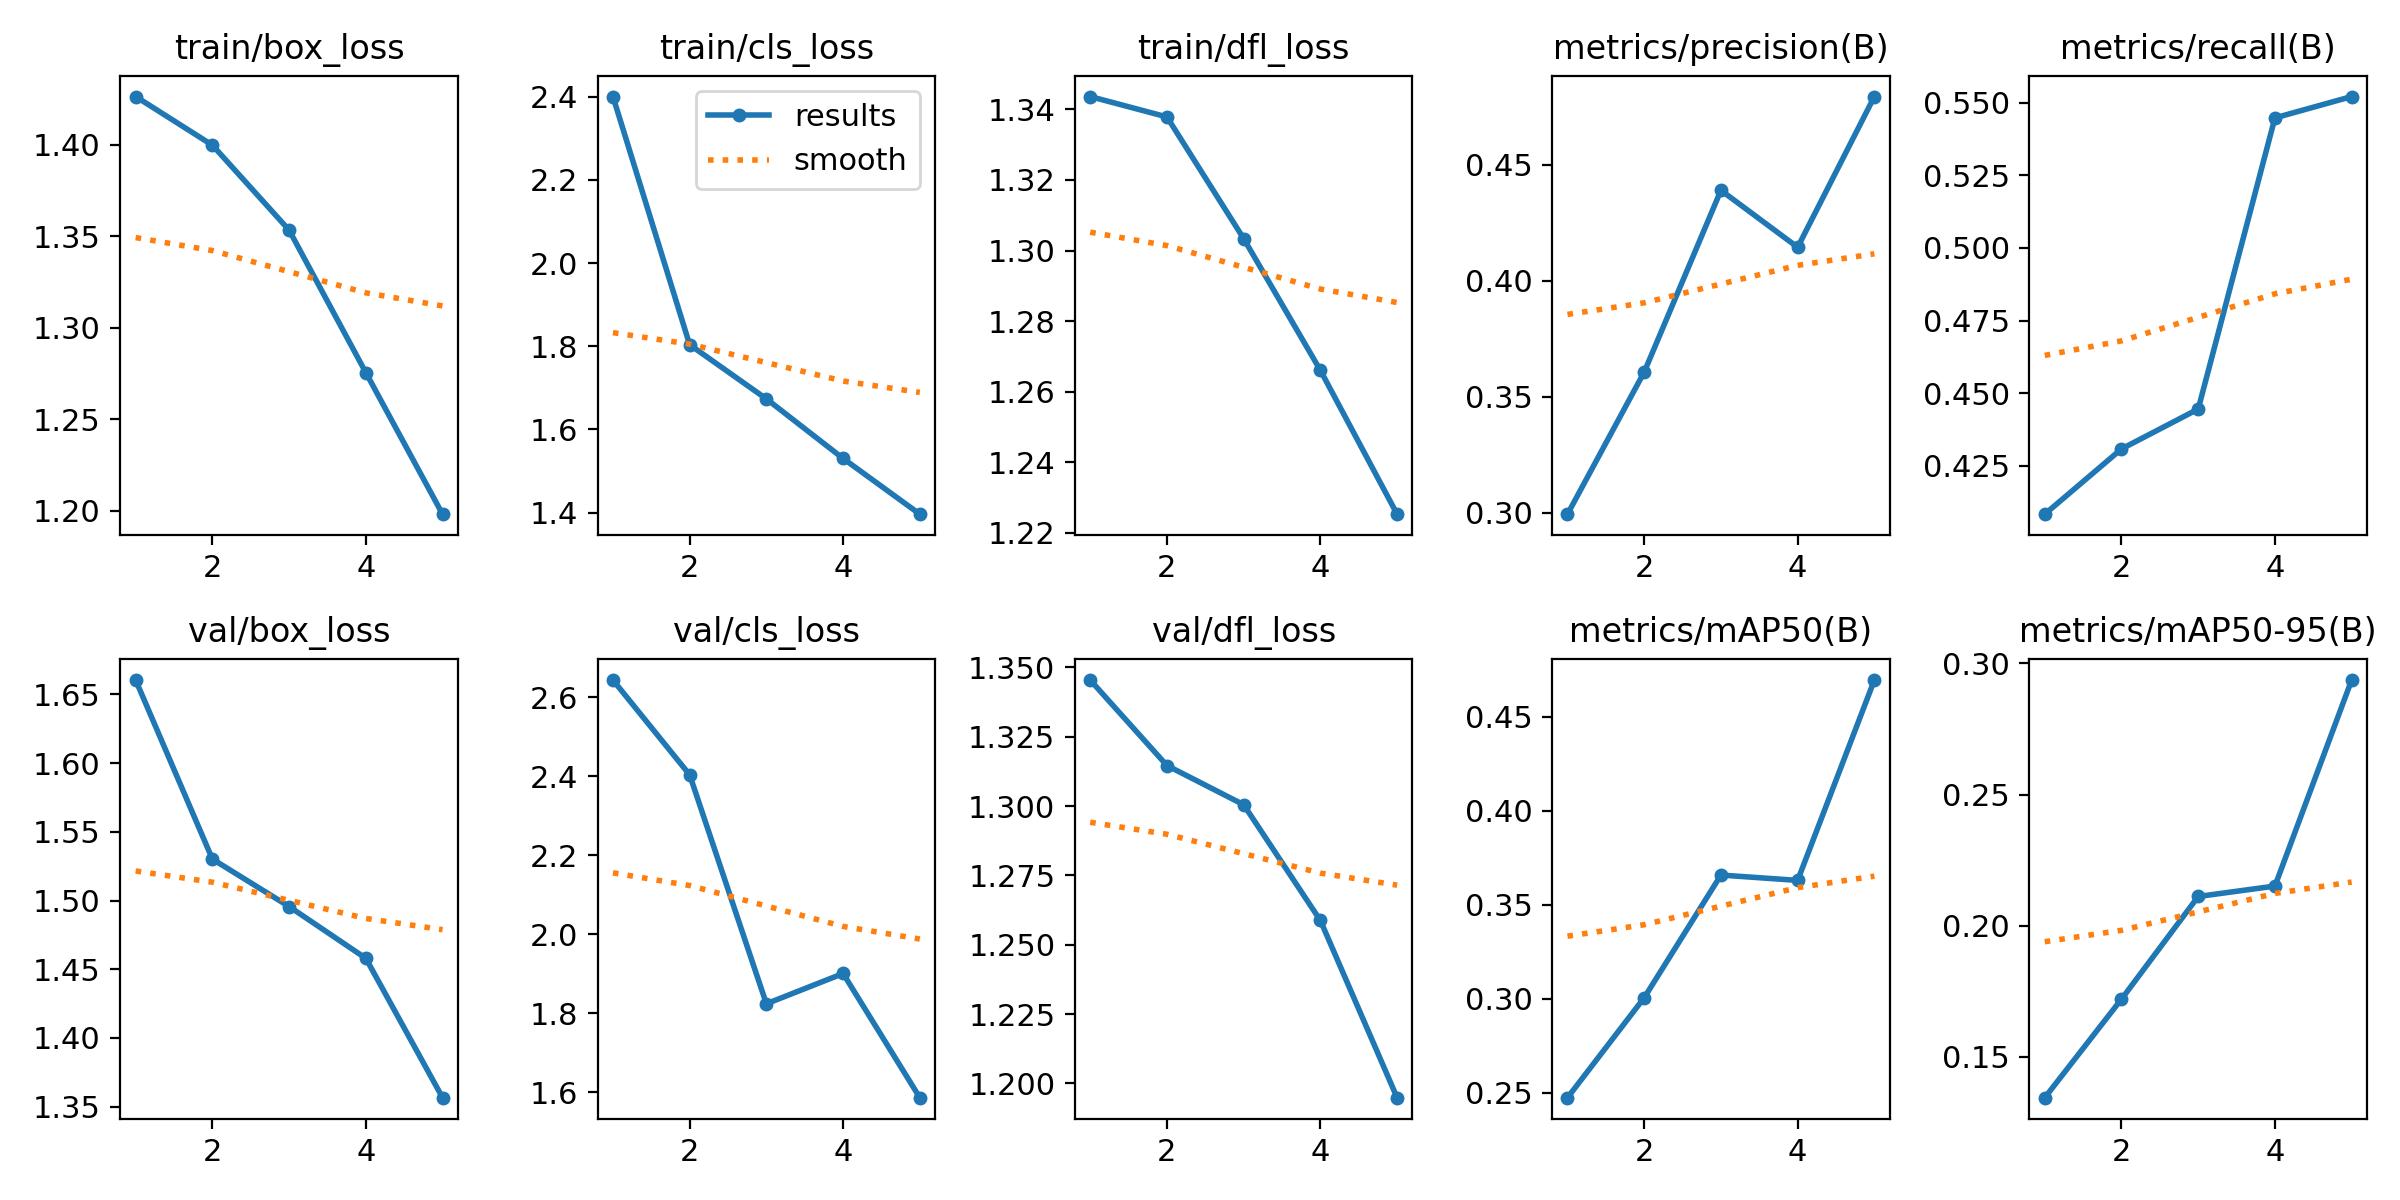

In [17]:
# Visualize evaluation results

from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/military_subset_yolo/results.png'))



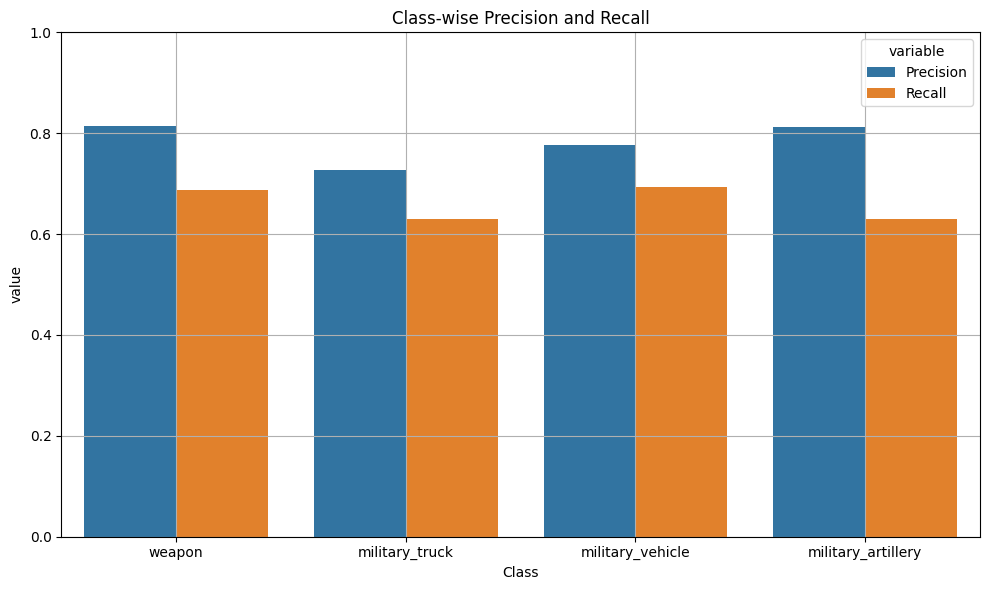

📌 Overall mAP@0.5: 0.737


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics from your output
classes = ["weapon", "military_truck", "military_vehicle", "military_artillery"]
precision = [0.81443, 0.72712, 0.77723, 0.81245]
recall = [0.68715, 0.63017, 0.69324, 0.62944]
map_50 = 0.73687

# Create DataFrame
df = pd.DataFrame({
    "Class": classes,
    "Precision": precision,
    "Recall": recall
})

# Plot bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df.melt(id_vars="Class"), x="Class", y="value", hue="variable")
plt.title("Class-wise Precision and Recall")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print summary
print("📌 Overall mAP@0.5:", round(map_50, 3))


# Optional: Save as CSV
df.to_csv("model_performance_report.csv", index=False)


# Inference AND Visualization

In [19]:
# Load the trained model

from ultralytics import YOLO

# Load your best saved model (update path if needed)
model = YOLO("/content/drive/MyDrive/military_subset_yolo/weights/best.pt")


In [20]:
# Predict on test images folder

# Run prediction on all test images
results = model.predict(
    source="/content/drive/MyDrive/Military/military_object_dataset/test/images",  # path to test images
    conf=0.3,               # confidence threshold
    save=True,              # saves output images with boxes to a folder
    save_txt=True,          # optional: saves prediction txt files (YOLO format)
    project="runs/predict", # output base folder
    name="military_infer",  # subfolder name
    exist_ok=True           # overwrite if exists
)




WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1396 /content/drive/MyDrive/Military/military_object_dataset/test/images/000001.jpg: 256x256 1 military_warship, 6.5ms
image 2/1396 /content/drive/MyDrive/Military/military_object_dataset/test/images/000002.jpg: 256x256 (no detections), 7.1ms
image 3/1396 /content/drive/MyDrive/Military/military_object_dataset/test/images/000003.jpg: 256x256 (no detections), 7.8ms
image 4/1396 /content/drive/MyDrive/Military/military_object_dataset/test/images/

In [21]:
# Display few output images --> CONTINUE FROM HERE

import matplotlib.pyplot as plt
import cv2
import os

# Change path based on output
output_path = "/content/drive/MyDrive/Military/BPT_output"

# List predicted images
# Only list image files
predicted_images = [f for f in os.listdir(output_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display first 3 predictions
for i in range(min(2, len(predicted_images))):
    img = cv2.imread(os.path.join(output_path, predicted_images[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_images[i]}")
    plt.axis('off')
    plt.show()

In [22]:
# save predictions to drive

!cp -r runs/predict/military_infer /content/drive/MyDrive/Military/BPT_output


## STREAMLIT

In [23]:
!pip install streamlit streamlit_option_menu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 107.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.1 MB/s eta 0:00:00


In [27]:
# @title Setup code
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
import subprocess
subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

--2025-10-04 12:51:05--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.9.1/cloudflared-linux-amd64 [following]
--2025-10-04 12:51:06--  https://github.com/cloudflare/cloudflared/releases/download/2025.9.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/e30ab3bb-4e6a-464a-8db5-d5cabe6a2f8d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-04T13%3A35%3A02Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-

In [28]:
%%writefile military.py

import streamlit as st
from ultralytics import YOLO
from PIL import Image
import numpy as np

st.title("Military Object Detection using YOLOv8")
st.markdown("Upload an image to detect")

# Load model
model = YOLO("/content/drive/MyDrive/military_subset_yolo/weights/best.pt")

uploaded_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    with st.spinner("Detecting..."):
        results = model.predict(img, conf=0.3)
        result_img = results[0].plot()

        st.image(result_img, caption="Detection Result", use_column_width=True)

        # Optional: show detected classes
        st.subheader("Detected Classes")
        for box in results[0].boxes.data:
            cls = int(box[-1])
            conf = box[-2].item()
            st.write(f"Class ID: {cls}, Confidence: {conf:.2f}")


Overwriting military.py


In [29]:
!streamlit run /content/military.py &>/content/logs.txt &

In [30]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://gadgets-shark-macintosh-theory.trycloudflare.com
